# Fitting the data to a ML Linear regression model

We will fit a model with the non-cumulative data and another with the cumulative data. This is because fitting both simultaneously can have an impact in the fit: the accumulated data can be "contradictory" with the non-cumulative.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('../ML_models/data_for_ML.csv').drop('Unnamed: 0',axis=1)

In [3]:
data.head()

,year,week,geoId,cases_per_100khab,cmltve_cases,first_dose_100k,cmltve_first_dose,second_dose_100k,cmltve_second_dose,deaths_per_100khab,cmltve_deaths
0,2020,0,AT,6.628421,12.886100,0.0,0.0,0.0,0.0,0.157285,0.280865
1,2020,1,AT,108.604994,242.139591,0.0,0.0,0.0,0.0,1.808773,3.505199
2,2020,5,AT,11.976096,847.932337,0.0,0.0,0.0,0.0,0.258396,15.245368
3,2020,6,AT,109.829566,572.571998,0.0,0.0,0.0,0.0,1.797538,9.010159
4,2020,8,AT,0.089877,948.369768,0.0,0.0,0.0,0.0,0.000000,16.087964


In [4]:
data['year']=data['year'].astype(str)
data['week']=data['week'].astype(str)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3667 entries, 0 to 3666
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                3667 non-null   object 
 1   week                3667 non-null   object 
 2   geoId               3667 non-null   object 
 3   cases_per_100khab   3667 non-null   float64
 4   cmltve_cases        3667 non-null   float64
 5   first_dose_100k     3667 non-null   float64
 6   cmltve_first_dose   3667 non-null   float64
 7   second_dose_100k    3667 non-null   float64
 8   cmltve_second_dose  3667 non-null   float64
 9   deaths_per_100khab  3667 non-null   float64
 10  cmltve_deaths       3667 non-null   float64
dtypes: float64(8), object(3)
memory usage: 315.3+ KB


## Non-cumulative data (data_new)

In [6]:
ncd=['year','week','geoId','cases_per_100khab','first_dose_100k','second_dose_100k','deaths_per_100khab']
data_new=data[ncd]

## EDA

### Numericals

In [7]:
data_new.describe().round(2)

,cases_per_100khab,first_dose_100k,second_dose_100k,deaths_per_100khab
count,3667.00,3667.00,3667.00,3667.00
mean,231.22,1419.92,1273.41,1.79
std,418.63,2795.19,2735.96,2.39
min,-407.19,0.00,0.00,-0.02
25%,28.71,0.00,0.00,0.24
50%,116.75,0.00,0.00,0.93
75%,261.09,1472.17,1138.27,2.44
max,6993.58,24286.06,26069.80,20.65


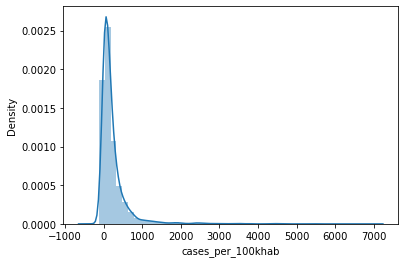

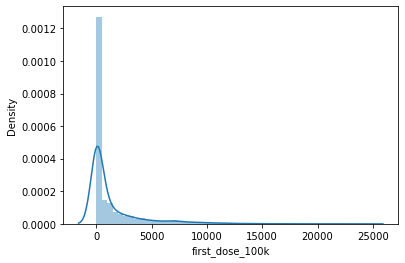

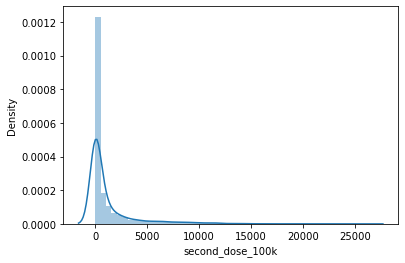

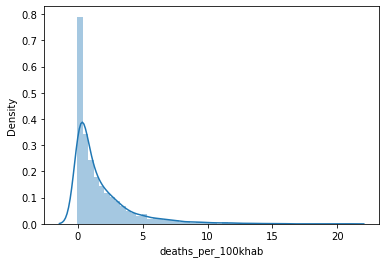

In [8]:
for column in data_new.select_dtypes(np.number).columns:
    sns.distplot(data_new[column])
    plt.show()

### Categoricals

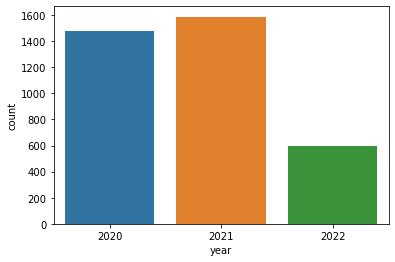

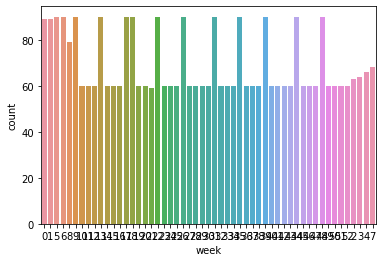

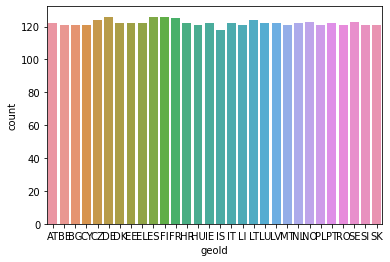

In [9]:
for col in data_new.select_dtypes(np.object).columns:
    sns.countplot(x=data_new[col]) #, hue=df['education']
    plt.show()

In [10]:
#data['week'].value_counts()

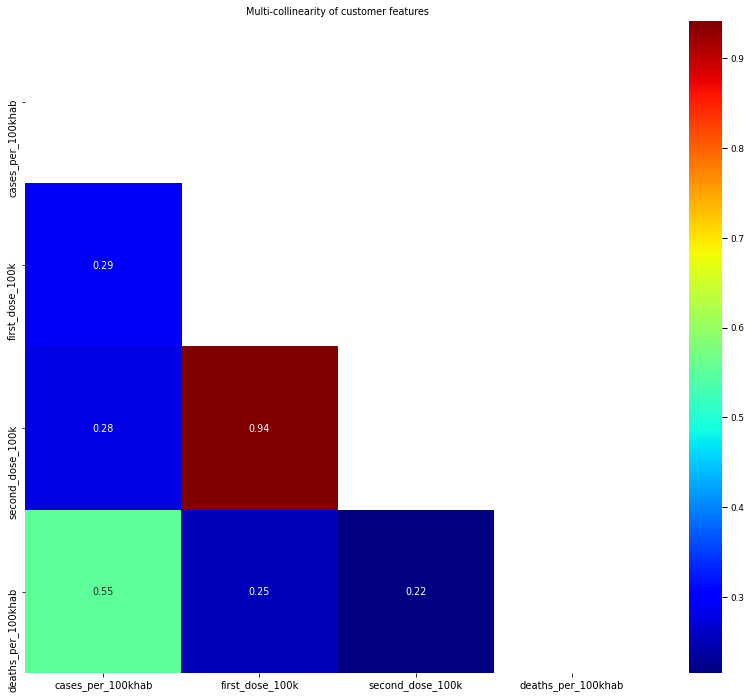

In [11]:
# Correlation matrix
corr_mat = data_new.corr(method='spearman')
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True # Mask to hide the repeated half of the matrix

fig, ax = plt.subplots(figsize=(14, 12)) # this will set the width and height of the plot
sns.set_context('paper') #This affects things like the size of the labels, lines, and other elements of the plot
ax = sns.heatmap(corr_mat, mask=mask, annot=True, cmap='jet') # Heatmap declaration
ax.set_title('Multi-collinearity of customer features') #Title for the graph
plt.show()

In [12]:
#data_new.drop('second_dose_100k', axis=1, inplace=True)

## Preprocessing

In [13]:
# X-y Split
y = data_new['deaths_per_100khab']
X = data_new.drop(['deaths_per_100khab'], axis=1)
X.columns

Index(['year', 'week', 'geoId', 'cases_per_100khab', 'first_dose_100k',
       'second_dose_100k'],
      dtype='object')

In [14]:
# Separate numerical and categorical values

X_num = X.select_dtypes(include='number')
X_cat = X.select_dtypes(exclude='number')

In [15]:
# One Hot Encoding categorical variables

encoder = OneHotEncoder(handle_unknown='error', drop='first') #drop one column for efficiency. It can be deduced
X_cat_encoded = encoder.fit_transform(X_cat).toarray()
X_cat_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [16]:
# Concat DataFrames

column_names = list(X_num.columns) # get list of numerical column names
column_names.extend(list(encoder.get_feature_names())) # add list of dummified categorical column names

X_numcat = np.concatenate([X_num, X_cat_encoded], axis=1)
X_ready = pd.DataFrame(data=X_numcat, index=X.index, columns=column_names)
X_ready.sample(5)

,cases_per_100khab,first_dose_100k,second_dose_100k,x0_2021,x0_2022,x1_1,x1_10,x1_11,x1_12,x1_13,x1_14,x1_15,x1_16,x1_17,x1_18,x1_19,x1_2,x1_20,x1_21,x1_22,x1_23,x1_24,x1_25,x1_26,x1_27,x1_28,x1_29,x1_3,x1_30,x1_31,x1_32,x1_33,x1_34,x1_35,x1_36,x1_37,x1_38,x1_39,x1_4,x1_40,x1_41,x1_42,x1_43,x1_44,x1_45,x1_46,x1_47,x1_48,x1_49,x1_5,x1_50,x1_51,x1_52,x1_6,x1_7,x1_8,x1_9,x2_BE,x2_BG,x2_CY,x2_CZ,x2_DE,x2_DK,x2_EE,x2_EL,x2_ES,x2_FI,x2_FR,x2_HR,x2_HU,x2_IE,x2_IS,x2_IT,x2_LI,x2_LT,x2_LU,x2_LV,x2_MT,x2_NL,x2_NO,x2_PL,x2_PT,x2_RO,x2_SE,x2_SI,x2_SK
3497,25.383363,2768.027078,3903.45543,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
864,12.791804,0.000000,0.00000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2836,2.049341,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1625,0.716514,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2710,6.945248,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=0.3, random_state=42)

### Model fitting

In [18]:
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)
scaler_y = StandardScaler().fit(y_train.to_numpy().reshape(-1, 1))

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Evaluation

In [20]:
predictions_norm = model.predict(X_test)
R2 = r2_score(y_test, predictions_norm)

predictions = scaler_y.inverse_transform(predictions_norm.reshape(-1, 1))

MAE = mean_absolute_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions, squared=True)
RMSE = mean_squared_error(y_test, predictions, squared=False)

print('R2 =',R2, 'MAE =', MAE, 'MSE =', MSE, 'RMSE =', RMSE)

R2 = 0.32042354521236127 MAE = 4.879898511991797 MSE = 32.90922057903131 RMSE = 5.736655870716955


,true,pred,resid
2178,0.000000,16.068905,16.068905
217,2.612294,18.348449,15.736155
254,0.187010,15.509232,15.322221
220,2.239109,17.312780,15.073671
226,1.570848,16.460094,14.889246
...,...,...,...
3328,0.290484,0.339434,0.048950
1741,0.181289,0.227011,0.045722
1313,0.162887,0.118708,0.044180
2933,0.000000,0.025245,0.025245


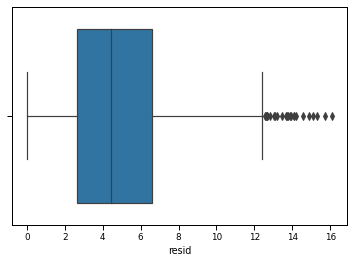

In [21]:
import math

results = pd.DataFrame()
results['true'] = y_test
results['pred'] = predictions
results['resid'] = results.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
results=results.sort_values('resid', ascending=False)

#results.to_csv('../Streamlit/LR_results.csv')

display(results)
sns.boxplot(x=results['resid'])
plt.show()

<AxesSubplot:xlabel='true', ylabel='pred'>

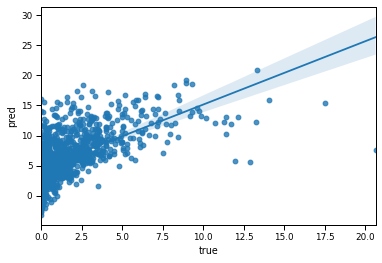

In [22]:
sns.regplot(results['true'], results['pred'])

### Check Multicollinearity with VIF

In [24]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor

#df_ready=pd.concat([y,X_ready],axis=1)
#df_ready

#Independent variables set
#ind_var=X_ready

#VIF dataframe
#vif_data = pd.DataFrame()
#vif_data['feature'] = ind_var.columns

#calculating VIF for each feature
#vif_data['VIF'] = [variance_inflation_factor(ind_var.values, i) for i in range(len(ind_var.columns))]

#vif_data['VIF'].replace([np.inf, -np.inf], np.nan, inplace=True)

#vif_data_filtered=vif_data[vif_data['VIF']>5]
#display(vif_data_filtered)

#sns.barplot(x=vif_data_filtered['feature'], y=vif_data_filtered['VIF']).set_yscale("log")
#plt.show()

This VIF analysis does not help much improving the model. All three numerical features have a high multicollinearity, so they cannot be used for a linear regression model.

In [36]:
X_ready.drop('second_dose_100k', axis=1, inplace=True)

In [37]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=0.3, random_state=42)

In [38]:
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)
scaler_y = StandardScaler().fit(y_train.to_numpy().reshape(-1, 1))

In [39]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [40]:
predictions_norm = model.predict(X_test)
R2 = r2_score(y_test, predictions_norm)

predictions = scaler_y.inverse_transform(predictions_norm.reshape(-1, 1))

MAE = mean_absolute_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions, squared=True)
RMSE = mean_squared_error(y_test, predictions, squared=False)

print('R2 =',R2, 'MAE =', MAE, 'MSE =', MSE, 'RMSE =', RMSE)

R2 = 0.32111350563936636 MAE = 4.877154924042398 MSE = 32.861916074968235 RMSE = 5.732531384560248


In [42]:
#Scaled metrics for comparison

y_test_scaled = scaler_y.transform (y_test.to_numpy().reshape(-1, 1))

MAE_s = mean_absolute_error(y_test_scaled, predictions_norm)
MSE_s = mean_squared_error(y_test_scaled, predictions_norm, squared=True)
RMSE_s = mean_squared_error(y_test_scaled, predictions_norm, squared=False)

In [46]:
metrics={'model':['LR'],'score':[R2],'mean_absolute_error':[MAE],'mean_squared_error':[MSE], 'RMSE':[RMSE]}
#metrics_df=pd.DataFrame(metrics)
metrics_df=pd.DataFrame(metrics)
display(metrics_df)
metrics_df.to_csv('../Streamlit/LR_metrics.csv')

,model,score,mean_absolute_error,mean_squared_error,RMSE
0,LR,0.321114,4.877155,32.861916,5.732531


,true,pred,resid
2178,0.000000,16.039840,16.039840
217,2.612294,18.290943,15.678649
254,0.187010,15.587821,15.400810
220,2.239109,17.254810,15.015700
226,1.570848,16.457755,14.886908
...,...,...,...
1309,0.108592,0.078681,0.029910
3328,0.290484,0.261194,0.029290
1741,0.181289,0.153385,0.027904
1745,0.141003,0.158087,0.017084


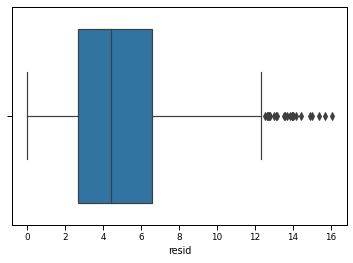

In [44]:
import math

results = pd.DataFrame()
results['true'] = y_test
results['pred'] = predictions
results['resid'] = results.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
results=results.sort_values('resid', ascending=False)

results.to_csv('../Streamlit/LR_results.csv')

display(results)
sns.boxplot(x=results['resid'])
plt.show()

<AxesSubplot:xlabel='true', ylabel='pred'>

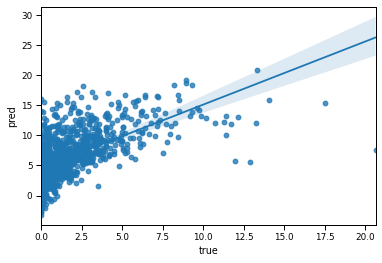

In [45]:
sns.regplot(results['true'], results['pred'])